In [2]:
import deluca
import jax
import control as ct
import numpy as np
from scipy.signal import cont2discrete
from scipy.signal import square
import jax.numpy as jnp
from deluca.agents._gpc import GPC
from deluca.agents._lqr import LQR
from tqdm import tqdm

In [3]:
def double_integrator_dt(m=1,b=0.5,k=5,dt=0.1): 
    A = np.array([[0, 1], [-k/m, -b/m]])
    B = np.array([[0], [1/m]])
    n_states = A.shape[0]
    C, D= np.eye(1,n_states), 0
    sys = cont2discrete((A,B,C,D), dt, method='zoh', alpha=None)
    A,B = sys[0], sys[1]
    return A,B,dt

In [4]:
def quad_loss(x: jnp.ndarray, u: jnp.ndarray):
    return (x.T @ Q @ x) + u.T @ R @u

In [5]:
def run_simulation(agpc, alqr, T, w2):
    # initialize states
    agpc.state = x0
    x_gpc = x0
    x_lqr = x0

    # intialize arrays of zeros
    uv_gpc, xv_gpc, wv_gpc, gv_gpc =  np.zeros((1,T)), np.zeros((2,T)), np.zeros((2,T)), np.zeros((1,T))
    cv_gpc = np.zeros((1,T))
    cv_lqr = np.zeros((1,T))
    uv_lqr, xv_lqr = np.zeros((1,T)), np.zeros((2,T))
    uv2_gpc = np.zeros((1,T))
    for i in tqdm(range(T)):
        #for i in range(T):

        # Compute disturbance 
        w = jnp.array([[0.],[w2[i]]])
        
        xv_gpc[:,i] = agpc.state.reshape((2,)) # put states into array
        xv_lqr[:,i] = x_lqr.reshape((2,)) # put the current state into a vector of all states
        
        # get control actions
        u_gpc, u2_gpc = agpc.get_action(agpc.state) # compute control action for GPC
        u_lqr = alqr(x_lqr) # compute the control action for the next iteration
        
        # compute cost
        c_gpc = quad_loss(x_gpc,u_gpc) # compute cost for GPC
        c_lqr = quad_loss(x_lqr,u_lqr) # compute cost for LQR
        
        # add noise and get next state
        x_gpc = agpc.A @ agpc.state + agpc.B @ u_gpc + w
        #w = (A_true @ agpc.state + B_true @ u_gpc) - (A @ agpc.state + B @ u_gpc) 
        agpc.update(x_gpc,u_gpc)
        
        #x_lqr = A_true @ x_lqr + B_true @ u_lqr # get the next state
        x_lqr = agpc.A @ x_lqr + agpc.B @ u_lqr + w
        
        # get policy loss
        g_gpc = agpc.policy_loss(agpc.M,agpc.noise_history)
        
        # put scalars into vectors
        uv_gpc[:,i], wv_gpc[:,i], gv_gpc[:,i] = u_gpc.reshape((1,)), w.reshape((2,)), g_gpc.reshape((1,))
        uv2_gpc[:,i] = u2_gpc.reshape((1,))
        cv_lqr[:,i] = c_lqr.reshape((1,))
        cv_gpc[:,i] = c_gpc.reshape((1,))
        uv_lqr[:,i] = u_lqr.reshape((1,)) 

    return xv_gpc, uv_gpc, wv_gpc, gv_gpc, cv_gpc, xv_lqr, uv_lqr, cv_lqr


In [20]:
import matplotlib.pyplot as plt
from matplotlib import rcParams


rcParams['font.family'],rcParams['font.serif'],rcParams['text.usetex'] = 'serif', ['Computer Modern Roman'], True
#plt.rcParams.update(plt.rcParamsDefault)

rcParams['font.size'], rcParams['axes.labelsize'],rcParams['axes.titlesize'] = 16, 16, 18
rcParams['xtick.labelsize'], rcParams['ytick.labelsize'] = 14, 14

In [143]:
# Square Wave Noise

A, B, dt = double_integrator_dt()
A_true, B_true, _ = double_integrator_dt(m=1.2, b=0.6, k=6)
Q, R = 500*jnp.eye(2), jnp.eye(1)

# initialize classes
agpc = GPC(
    A=A,
    B=B,
    Q = Q,
    R = R,
    H=4,
    HH=3,
    lr_scale=0.00005,
    decay= True,
    )
alqr = LQR(A,B,Q,R)

T = 200
x0 = jnp.array([[0],[0]])
tv = np.arange(0,T)*dt
w2 = 100*dt*square(tv*0.3,duty=0.5)

xv_gpc, uv_gpc, wv_gpc, gv_gpc, cv_gpc, xv_lqr, uv_lqr, cv_lqr = run_simulation(agpc, alqr, T, w2)




[ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.  10.
  10.  10.  10.  10.  10.  10.  10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10. -10.
 -10. 

100%|██████████| 200/200 [00:08<00:00, 22.76it/s]


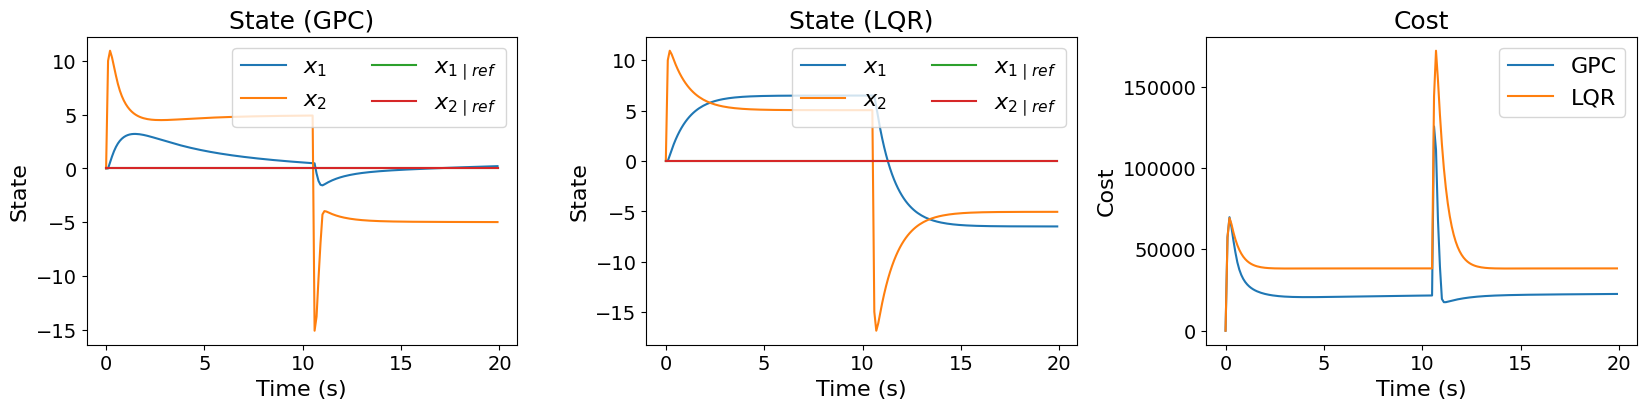

In [132]:
fig1, ax1 = plt.subplots(1, 3, figsize=(20, 4)) # Create a figure and axis for GPC
ax1[0].plot(tv,xv_gpc[0,:],label="$x_1$")
ax1[0].plot(tv,xv_gpc[1,:],label="$x_2$")
ax1[0].plot(tv, np.zeros_like(tv),label="$x_{1 \mid {ref}}$")
ax1[0].plot(tv, np.zeros_like(tv),label="$x_{2 \mid {ref}}$")
ax1[0].set_title("State (GPC)")
ax1[0].set_xlabel("Time (s)")
ax1[0].set_ylabel("State")
ax1[0].legend(loc="upper right", ncol=2)

ax1[1].plot(tv,xv_lqr[0,:],label="$x_1$")
ax1[1].plot(tv,xv_lqr[1,:],label="$x_2$")
ax1[1].plot(tv, np.zeros_like(tv),label="$x_{1 \mid {ref}}$")
ax1[1].plot(tv, np.zeros_like(tv),label="$x_{2 \mid {ref}}$")
ax1[1].set_title("State (LQR)")
ax1[1].set_xlabel("Time (s)")
ax1[1].set_ylabel("State")
ax1[1].legend(loc="upper right", ncol=2)

ax1[2].plot(tv, cv_gpc[0,:],label='GPC')
ax1[2].plot(tv, cv_lqr[0,:],label='LQR')
ax1[2].set_title("Cost")
ax1[2].set_xlabel("Time (s)")
ax1[2].set_ylabel("Cost")
ax1[2].legend(loc="upper right", ncol=1)

plt.subplots_adjust(wspace=0.3, hspace=0.7)
plt.show()

In [133]:
# Constant Offset Noise

A, B, dt = double_integrator_dt()
A_true, B_true, _ = double_integrator_dt(m=1.2, b=0.6, k=6)
Q, R = 500*jnp.eye(2), jnp.eye(1)

# initialize classes
agpc = GPC(
    A=A,
    B=B,
    Q = Q,
    R = R,
    H=4,
    HH=3,
    lr_scale=0.00005,
    decay= True,
    )
alqr = LQR(A,B,Q,R)

T = 200
x0 = jnp.array([[0],[0]])
tv = np.arange(0,T)*dt
w2 = 100*dt*np.ones_like(tv)

xv_gpc, uv_gpc, wv_gpc, gv_gpc, cv_gpc, xv_lqr, uv_lqr, cv_lqr = run_simulation(agpc, alqr, T, w2)

100%|██████████| 200/200 [00:07<00:00, 26.71it/s]


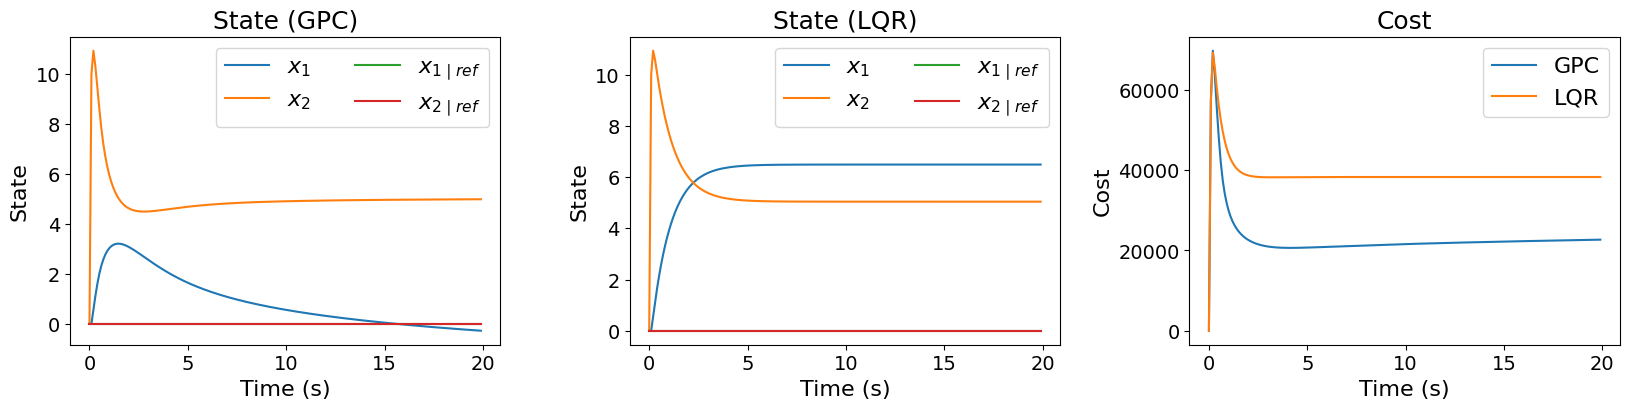

In [134]:
fig1, ax1 = plt.subplots(1, 3, figsize=(20, 4)) # Create a figure and axis for GPC
ax1[0].plot(tv,xv_gpc[0,:],label="$x_1$")
ax1[0].plot(tv,xv_gpc[1,:],label="$x_2$")
ax1[0].plot(tv, np.zeros_like(tv),label="$x_{1 \mid {ref}}$")
ax1[0].plot(tv, np.zeros_like(tv),label="$x_{2 \mid {ref}}$")
ax1[0].set_title("State (GPC)")
ax1[0].set_xlabel("Time (s)")
ax1[0].set_ylabel("State")
ax1[0].legend(loc="upper right", ncol=2)

ax1[1].plot(tv,xv_lqr[0,:],label="$x_1$")
ax1[1].plot(tv,xv_lqr[1,:],label="$x_2$")
ax1[1].plot(tv, np.zeros_like(tv),label="$x_{1 \mid {ref}}$")
ax1[1].plot(tv, np.zeros_like(tv),label="$x_{2 \mid {ref}}$")
ax1[1].set_title("State (LQR)")
ax1[1].set_xlabel("Time (s)")
ax1[1].set_ylabel("State")
ax1[1].legend(loc="upper right", ncol=2)

ax1[2].plot(tv, cv_gpc[0,:],label='GPC')
ax1[2].plot(tv, cv_lqr[0,:],label='LQR')
ax1[2].set_title("Cost")
ax1[2].set_xlabel("Time (s)")
ax1[2].set_ylabel("Cost")
ax1[2].legend(loc="upper right", ncol=1)

plt.subplots_adjust(wspace=0.3, hspace=0.7)
plt.show()

In [135]:
# Gaussian Noise

A, B, dt = double_integrator_dt()
A_true, B_true, _ = double_integrator_dt(m=1.2, b=0.6, k=6)
Q, R = 500*jnp.eye(2), jnp.eye(1)

# initialize classes
agpc = GPC(
    A=A,
    B=B,
    Q = Q,
    R = R,
    H=4,
    HH=3,
    lr_scale=0.00005,
    decay= True,
    )
alqr = LQR(A,B,Q,R)

T = 200
x0 = jnp.array([[0],[0]])
tv = np.arange(0,T)*dt
w2 = 10*dt*np.random.normal(0,1.0,np.size(tv))

xv_gpc, uv_gpc, wv_gpc, gv_gpc, cv_gpc, xv_lqr, uv_lqr, cv_lqr = run_simulation(agpc, alqr, T, w2)

100%|██████████| 200/200 [16:42<00:00,  5.01s/it]


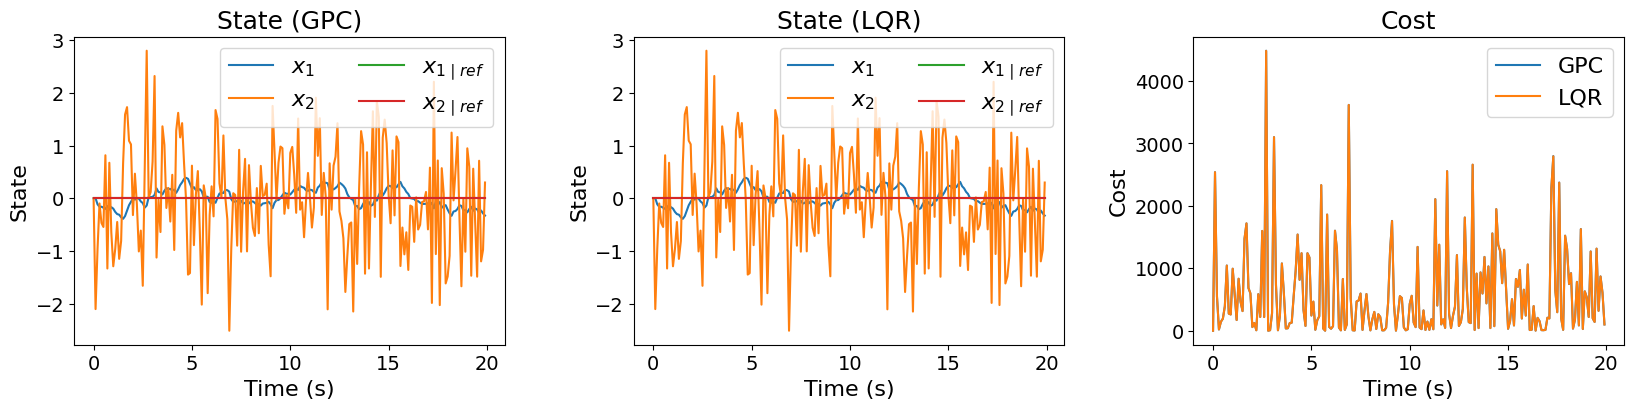

In [136]:
fig1, ax1 = plt.subplots(1, 3, figsize=(20, 4)) # Create a figure and axis for GPC
ax1[0].plot(tv,xv_gpc[0,:],label="$x_1$")
ax1[0].plot(tv,xv_gpc[1,:],label="$x_2$")
ax1[0].plot(tv, np.zeros_like(tv),label="$x_{1 \mid {ref}}$")
ax1[0].plot(tv, np.zeros_like(tv),label="$x_{2 \mid {ref}}$")
ax1[0].set_title("State (GPC)")
ax1[0].set_xlabel("Time (s)")
ax1[0].set_ylabel("State")
ax1[0].legend(loc="upper right", ncol=2)

ax1[1].plot(tv,xv_lqr[0,:],label="$x_1$")
ax1[1].plot(tv,xv_lqr[1,:],label="$x_2$")
ax1[1].plot(tv, np.zeros_like(tv),label="$x_{1 \mid {ref}}$")
ax1[1].plot(tv, np.zeros_like(tv),label="$x_{2 \mid {ref}}$")
ax1[1].set_title("State (LQR)")
ax1[1].set_xlabel("Time (s)")
ax1[1].set_ylabel("State")
ax1[1].legend(loc="upper right", ncol=2)

ax1[2].plot(tv, cv_gpc[0,:],label='GPC')
ax1[2].plot(tv, cv_lqr[0,:],label='LQR')
ax1[2].set_title("Cost")
ax1[2].set_xlabel("Time (s)")
ax1[2].set_ylabel("Cost")
ax1[2].legend(loc="upper right", ncol=1)

plt.subplots_adjust(wspace=0.3, hspace=0.7)
plt.show()

In [137]:
# Vary H
cost_H = np.array([])
Hv = np.array([])

for H_test in range(2,12):

    A, B, dt = double_integrator_dt()
    A_true, B_true, _ = double_integrator_dt(m=1.2, b=0.6, k=6)
    Q, R = 500*jnp.eye(2), jnp.eye(1)

    # initialize classes
    agpc = GPC(
        A=A,
        B=B,
        Q = Q,
        R = R,
        H=H_test,
        HH=H_test-1,
        lr_scale=0.00005,
        decay= True,
        )
    alqr = LQR(A,B,Q,R)

    T = 200
    x0 = jnp.array([[0],[0]])
    tv = np.arange(0,T)*dt
    w2 = 100*dt*square(tv*0.3,duty=0.5)

    xv_gpc, uv_gpc, wv_gpc, gv_gpc, cv_gpc, xv_lqr, uv_lqr, cv_lqr = run_simulation(agpc, alqr, T, w2)
    cost_H = np.append(cost_H, np.sum(cv_gpc))
    Hv = np.append(Hv, H_test)
        

 42%|████▎     | 85/200 [00:03<00:03, 32.38it/s]2024-05-04 00:43:38.417302: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 17m22.912533s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
 68%|██████▊   | 135/200 [16:40<00:02, 26.99it/s]  2024-05-04 01:28:53.111418: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 9m48.672696s

********************************
[Compiling module jit_scan] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
100%|██████████| 200/200 [00:09<00:00, 20.88it/s]


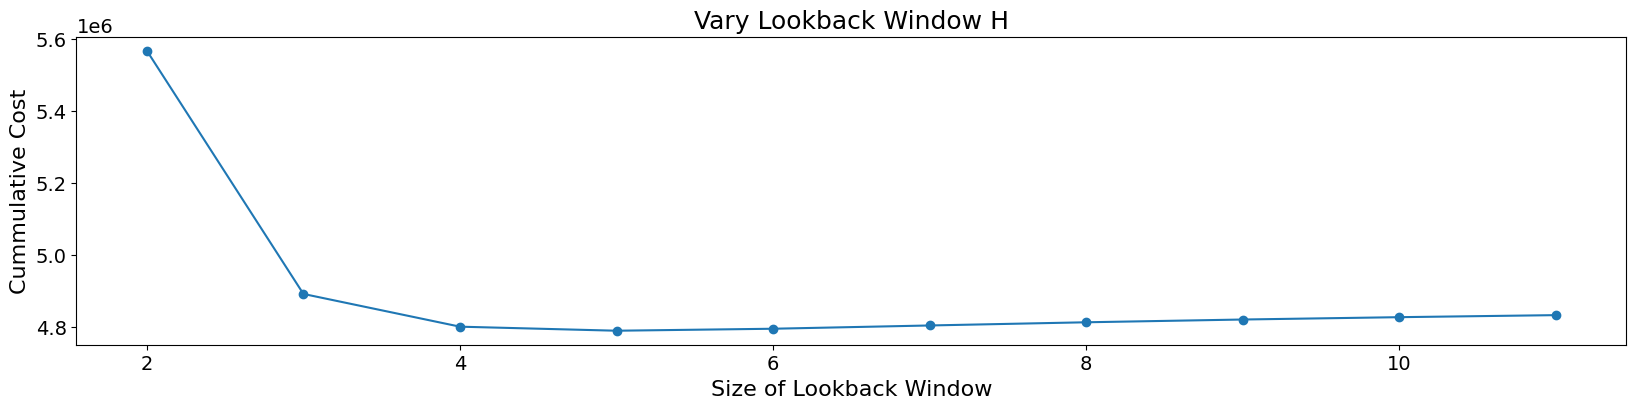

In [138]:
fig1, ax1 = plt.subplots(1, 1, figsize=(20, 4)) # Create a figure and axis for GPC
ax1.plot(Hv,cost_H)
ax1.scatter(Hv,cost_H)
ax1.set_title("Vary Lookback Window H")
ax1.set_xlabel("Size of Lookback Window")
ax1.set_ylabel("Cummulative Cost")


plt.subplots_adjust(wspace=0.3, hspace=0.7)
plt.show()

In [139]:
# Vary learning rate
cost_lr = np.array([])
learning_rates = np.array([0.000001, 0.00001, 0.00004, 0.00005, 0.00006, 0.00009, 0.0001, 0.0002, 0.0005, 0.001, 0.002])


for lr_test in learning_rates:

    A, B, dt = double_integrator_dt()
    A_true, B_true, _ = double_integrator_dt(m=1.2, b=0.6, k=6)
    Q, R = 500*jnp.eye(2), jnp.eye(1)

    # initialize classes
    agpc = GPC(
        A=A,
        B=B,
        Q = Q,
        R = R,
        H=4,
        HH=3,
        lr_scale=lr_test,
        decay= True,
        )
    alqr = LQR(A,B,Q,R)

    T = 200
    x0 = jnp.array([[0],[0]])
    tv = np.arange(0,T)*dt
    w2 = 100*dt*square(tv*0.3,duty=0.5)

    xv_gpc, uv_gpc, wv_gpc, gv_gpc, cv_gpc, xv_lqr, uv_lqr, cv_lqr = run_simulation(agpc, alqr, T, w2)
    cost_lr = np.append(cost_lr, np.sum(cv_gpc))

100%|██████████| 200/200 [00:07<00:00, 28.41it/s]


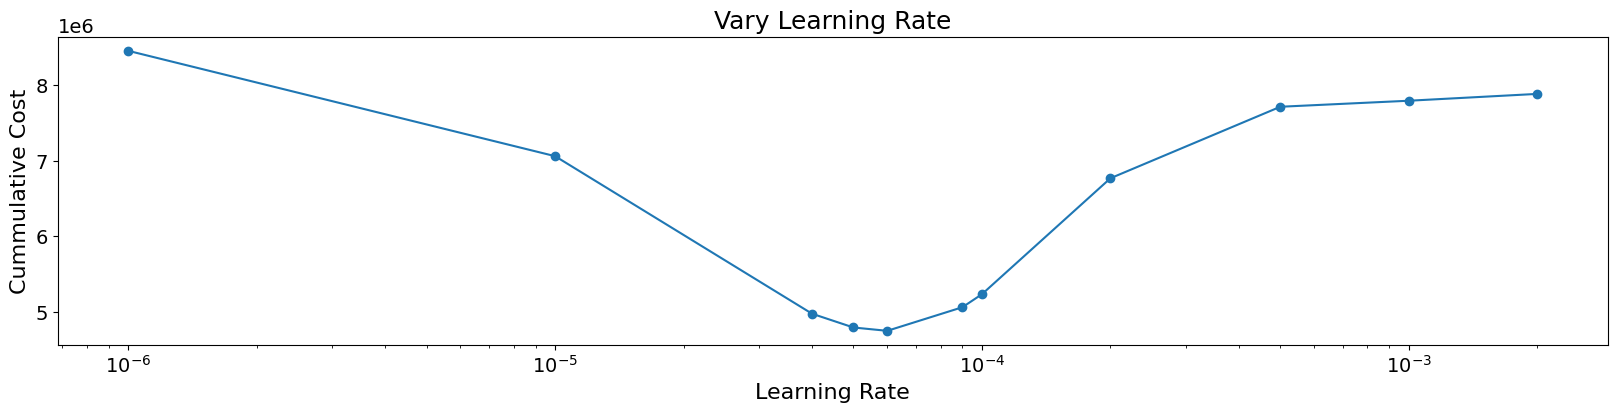

In [140]:
fig1, ax1 = plt.subplots(1, 1, figsize=(20, 4)) # Create a figure and axis for GPC
ax1.plot(learning_rates,cost_lr)
ax1.scatter(learning_rates,cost_lr)
ax1.set_title("Vary Learning Rate")
ax1.set_xscale('log')
ax1.set_xlabel("Learning Rate")
ax1.set_ylabel("Cummulative Cost")

plt.subplots_adjust(wspace=0.3, hspace=0.7)
plt.show()

In [11]:
# Vary learning rate
cost_Q = np.array([])
cost_Q_lqr = np.array([])
Q_vect = np.linspace(1,500,6)


for Q_test in Q_vect:

    A, B, dt = double_integrator_dt()
    A_true, B_true, _ = double_integrator_dt(m=1.2, b=0.6, k=6)
    Q, R = Q_test*jnp.eye(2), jnp.eye(1)

    # initialize classes
    agpc = GPC(
        A=A,
        B=B,
        Q = Q,
        R = R,
        H=4,
        HH=3,
        lr_scale=0.00005,
        decay= True,
        )
    alqr = LQR(A,B,Q,R)

    T = 200
    x0 = jnp.array([[0],[0]])
    tv = np.arange(0,T)*dt
    w2 = 100*dt*square(tv*0.3,duty=0.5) + 1

    xv_gpc, uv_gpc, wv_gpc, gv_gpc, cv_gpc, xv_lqr, uv_lqr, cv_lqr = run_simulation(agpc, alqr, T, w2)
    cost_Q = np.append(cost_Q, np.sum(cv_gpc))
    cost_Q_lqr = np.append(cost_Q_lqr, np.sum(cv_lqr))

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:06<00:00, 29.43it/s]


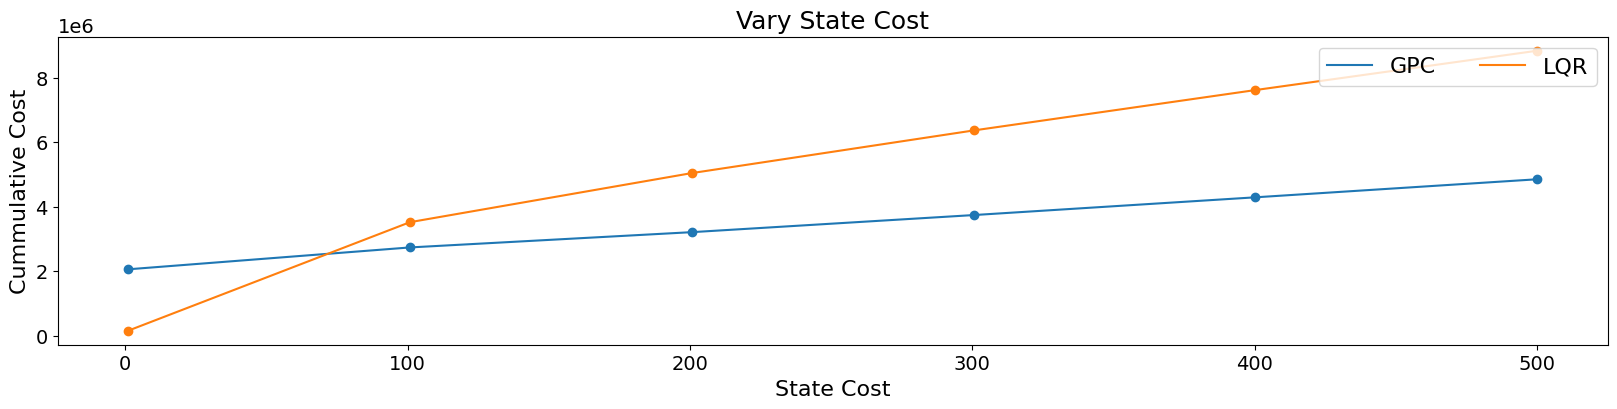

In [12]:
fig1, ax1 = plt.subplots(1, 1, figsize=(20, 4)) # Create a figure and axis for GPC
ax1.plot(Q_vect,cost_Q,label='GPC')
ax1.plot(Q_vect,cost_Q_lqr,label='LQR')
ax1.scatter(Q_vect,cost_Q)
ax1.set_title("Vary State Cost")
ax1.set_xlabel("State Cost")
ax1.scatter(Q_vect,cost_Q_lqr)
ax1.set_ylabel("Cummulative Cost")
ax1.legend(loc="upper right", ncol=2)

plt.subplots_adjust(wspace=0.3, hspace=0.7)
plt.show()

In [22]:
# vary m
cost_m = np.array([])
cost_m_lqr = np.array([])
m_vect = np.linspace(0.5,5,10)


for m_test in m_vect:

    A, B, dt = double_integrator_dt(m=m_test, b=0.5, k=5)
    Q, R = 500*jnp.eye(2), jnp.eye(1)

    # initialize classes
    agpc = GPC(
        A=A,
        B=B,
        Q = Q,
        R = R,
        H=4,
        HH=3,
        lr_scale=0.00005,
        decay= True,
        )
    alqr = LQR(A,B,Q,R)

    T = 200
    x0 = jnp.array([[0],[0]])
    tv = np.arange(0,T)*dt
    w2 = 100*dt*square(tv*0.3,duty=0.5) + 1

    xv_gpc, uv_gpc, wv_gpc, gv_gpc, cv_gpc, xv_lqr, uv_lqr, cv_lqr = run_simulation(agpc, alqr, T, w2)
    cost_m = np.append(cost_m, np.sum(cv_gpc))
    cost_m_lqr = np.append(cost_m_lqr, np.sum(cv_lqr))


# vary b
cost_b = np.array([])
cost_b_lqr = np.array([])
b_vect = np.linspace(0.01,1,10)


for b_test in b_vect:

    A, B, dt = double_integrator_dt(m=1, b=b_test, k=5)
    Q, R = 500*jnp.eye(2), jnp.eye(1)

    # initialize classes
    agpc = GPC(
        A=A,
        B=B,
        Q = Q,
        R = R,
        H=4,
        HH=3,
        lr_scale=0.00005,
        decay= True,
        )
    alqr = LQR(A,B,Q,R)

    T = 200
    x0 = jnp.array([[0],[0]])
    tv = np.arange(0,T)*dt
    w2 = 100*dt*square(tv*0.3,duty=0.5) + 1

    xv_gpc, uv_gpc, wv_gpc, gv_gpc, cv_gpc, xv_lqr, uv_lqr, cv_lqr = run_simulation(agpc, alqr, T, w2)
    cost_b = np.append(cost_b, np.sum(cv_gpc))
    cost_b_lqr = np.append(cost_b_lqr, np.sum(cv_lqr))

# vary k
cost_k = np.array([])
cost_k_lqr = np.array([])
k_vect = np.linspace(1,10,10)


for k_test in k_vect:

    A, B, dt = double_integrator_dt(m=1, b=0.5, k=k_test)
    Q, R = 500*jnp.eye(2), jnp.eye(1)

    # initialize classes
    agpc = GPC(
        A=A,
        B=B,
        Q = Q,
        R = R,
        H=4,
        HH=3,
        lr_scale=0.00005,
        decay= True,
        )
    alqr = LQR(A,B,Q,R)

    T = 200
    x0 = jnp.array([[0],[0]])
    tv = np.arange(0,T)*dt
    w2 = 100*dt*square(tv*0.3,duty=0.5) + 1

    xv_gpc, uv_gpc, wv_gpc, gv_gpc, cv_gpc, xv_lqr, uv_lqr, cv_lqr = run_simulation(agpc, alqr, T, w2)
    cost_k = np.append(cost_k, np.sum(cv_gpc))
    cost_k_lqr = np.append(cost_k_lqr, np.sum(cv_lqr))

100%|██████████| 200/200 [00:07<00:00, 26.61it/s]


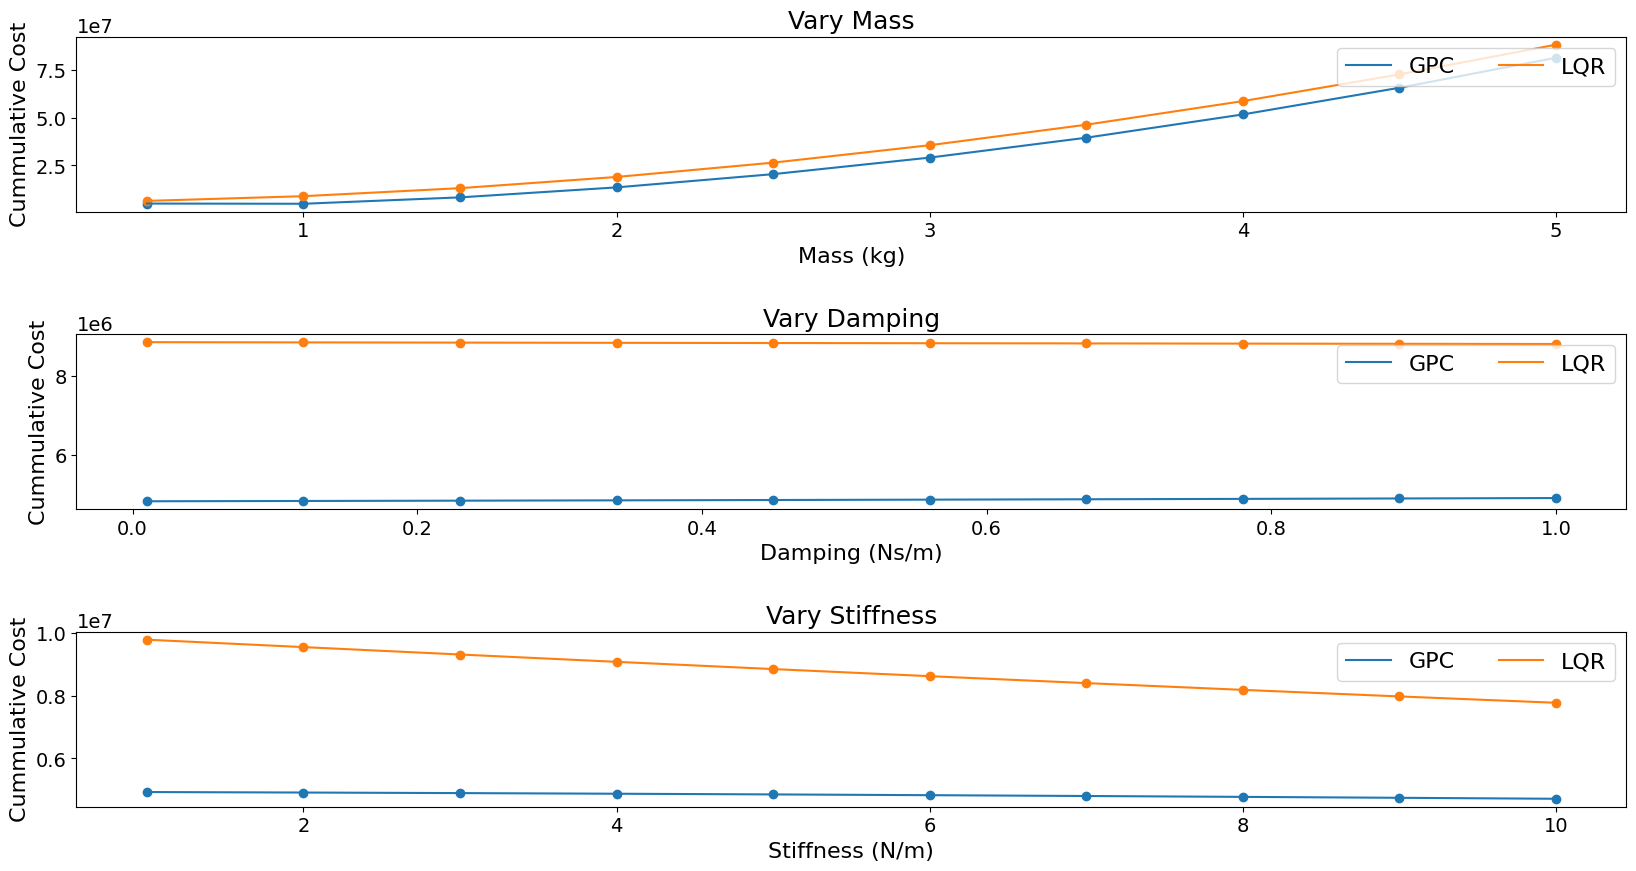

In [26]:
fig1, ax1 = plt.subplots(3, 1, figsize=(20, 10)) # Create a figure and axis for GPC
ax1[0].plot(m_vect,cost_m,label='GPC')
ax1[0].plot(m_vect,cost_m_lqr,label='LQR')
ax1[0].scatter(m_vect,cost_m)
ax1[0].set_title("Vary Mass")
ax1[0].set_xlabel("Mass (kg)")
ax1[0].scatter(m_vect,cost_m_lqr)
ax1[0].set_ylabel("Cummulative Cost")
ax1[0].legend(loc="upper right", ncol=2)

ax1[1].plot(b_vect,cost_b,label='GPC')
ax1[1].plot(b_vect,cost_b_lqr,label='LQR')
ax1[1].scatter(b_vect,cost_b)
ax1[1].set_title("Vary Damping")
ax1[1].set_xlabel("Damping (Ns/m)")
ax1[1].scatter(b_vect,cost_b_lqr)
ax1[1].set_ylabel("Cummulative Cost")
ax1[1].legend(loc="upper right", ncol=2)

ax1[2].plot(k_vect,cost_k,label='GPC')
ax1[2].plot(k_vect,cost_k_lqr,label='LQR')
ax1[2].scatter(k_vect,cost_k)
ax1[2].set_title("Vary Stiffness")
ax1[2].set_xlabel("Stiffness (N/m)")
ax1[2].scatter(k_vect,cost_k_lqr)
ax1[2].set_ylabel("Cummulative Cost")
ax1[2].legend(loc="upper right", ncol=2)

plt.subplots_adjust(wspace=0.3, hspace=0.7)
plt.show()


